# Performing Validation of generatin FAC coordinate transformation matrix
Date Created: 31-Oct-2025

Date Modified: 3-Nov-2025

Author: Regis John

In [47]:
import pyspedas
import numpy as np
import matplotlib.pyplot as plt

In [48]:
trange = ['2015-12-09/05:03:55', '2015-12-09/05:03:59']

Reading in magnetic and electric field data:

In [49]:
fgm_vars = pyspedas.mms.fgm(trange=trange, probe=1, data_rate='brst',
                            varformat='mms1_fgm_b_gse_brst_l2', time_clip=True)

06-Nov-25 10:49:58: Loading files for group: probe: 1, drate: brst, level: l2, datatype: , after sorting and filtering:
06-Nov-25 10:49:58: /Users/rejohn/Data_Speedas/mms/mms1/fgm/brst/l2/2015/12/09/mms1_fgm_brst_l2_20151209050044_v4.22.0.cdf


In [50]:
edp_vars = pyspedas.mms.edp(trange=trange,
                            probe=1,
                            data_rate='brst',
                            varnames=['mms1_edp_dce_gse_brst_l2', 'mms1_edp_dce_par_epar_brst_l2'],
                            time_clip=True)

06-Nov-25 10:50:00: Loading files for group: probe: 1, drate: brst, level: l2, datatype: dce, after sorting and filtering:
06-Nov-25 10:50:00: /Users/rejohn/Data_Speedas/mms/mms1/edp/brst/l2/dce/2015/12/09/mms1_edp_brst_l2_dce_20151209050044_v2.2.0.cdf


In [51]:
pyspedas.tplot_names()

0 : mms1_fgm_b_gse_brst_l2
1 : bvec_gse
2 : mms1_fgm_b_gse_brst_l2_btot
3 : evec_gse
4 : epar_gse
5 : bvec_gse_avg
6 : evec_gse_avg
7 : epar_gse_avg
8 : epar_gse_avg_noerr
9 : fac_matrix
10 : evec_gse_fac
11 : epar_gse_fac
12 : bhat_gse
13 : epar_gse_dotp
14 : combined_epar  data from:  epar_gse_avg_noerr epar_gse_fac epar_gse_dotp
15 : mms1_fgm_b_gse_brst_l2_bvec
16 : mms1_edp_dce_gse_brst_l2
17 : mms1_edp_dce_par_epar_brst_l2


['mms1_fgm_b_gse_brst_l2',
 'bvec_gse',
 'mms1_fgm_b_gse_brst_l2_btot',
 'evec_gse',
 'epar_gse',
 'bvec_gse_avg',
 'evec_gse_avg',
 'epar_gse_avg',
 'epar_gse_avg_noerr',
 'fac_matrix',
 'evec_gse_fac',
 'epar_gse_fac',
 'bhat_gse',
 'epar_gse_dotp',
 'combined_epar  data from:  epar_gse_avg_noerr epar_gse_fac epar_gse_dotp',
 'mms1_fgm_b_gse_brst_l2_bvec',
 'mms1_edp_dce_gse_brst_l2',
 'mms1_edp_dce_par_epar_brst_l2']

In [52]:
pyspedas.tplot_rename('mms1_fgm_b_gse_brst_l2_bvec', 'bvec_gse')
pyspedas.tplot_rename('mms1_edp_dce_gse_brst_l2', 'evec_gse')
pyspedas.tplot_rename('mms1_edp_dce_par_epar_brst_l2', 'epar_gse')

### Downsampling to DES cadence of 30 ms

In [53]:
# Define target cadence
des_cadence = 0.03  # seconds or 30 ms

In [54]:
# 1. Downsample magnetic field (native ~128 Hz → 33 Hz)
pyspedas.avg_data('bvec_gse', res=des_cadence, newname='bvec_gse_avg')

06-Nov-25 10:50:01: avg_data was applied to: bvec_gse_avg


['bvec_gse_avg']

In [55]:
# 2. Downsample electric field (native 8192 Hz → 33 Hz)
pyspedas.avg_data('evec_gse', res=des_cadence, newname='evec_gse_avg')

06-Nov-25 10:50:01: avg_data was applied to: evec_gse_avg


['evec_gse_avg']

In [56]:
# 2. Downsample parallel electric field (native 8192 Hz → 33 Hz)
pyspedas.avg_data('epar_gse', res=des_cadence, newname='epar_gse_avg')

06-Nov-25 10:50:01: avg_data was applied to: epar_gse_avg


['epar_gse_avg']

## Testing FAC matrix implementation

To validate the inbuilt fac subroutine in PySPEDAS, we perform the following checks:

1. Plot the raw field-aligned electric field ($E_{\parallel}$) from MMS data.
2. Use the fac subroutine to compute $E_{\parallel}$ and plot the result.
3. Independently estimate the magnetic field direction, project the electric field onto it, and normalize by |B| to obtain $E_{\parallel}$.

If all three methods yield consistent $E_{\parallel}$ profiles, the transformation is verified.

### 1. Raw field-aligned electric field ($E_{\parallel}$) from MMS data:

In [57]:
times, epar_gse_avg = pyspedas.get_data('epar_gse_avg')
epar_gse_avg_noerr = epar_gse_avg[:, 1]  # Exclude error component
pyspedas.store_data('epar_gse_avg_noerr', data={'x': times, 'y': epar_gse_avg_noerr})

True

### 2. Estimating $E_{\parallel}$ using the inbuilt FAC functions:

In [58]:
# Using inbuilt FAC functions:
pyspedas.fac_matrix_make(mag_var_name='bvec_gse_avg', other_dim='Xgse', newname='fac_matrix')

06-Nov-25 10:50:01: store_data: Neither data array nor newname supplied, nothing to do.


'fac_matrix'

In [59]:
# Rotate the interpolated E vector using the created matrix
print("Rotating evec_gse_avg to FAC coordinates...")
pyspedas.tvector_rotate(mat_var_in='fac_matrix', vec_var_in='evec_gse_avg', 
                        newname='evec_gse_fac')

06-Nov-25 10:50:02: Setting coordinate system for evec_gse_fac


Rotating evec_gse_avg to FAC coordinates...


['evec_gse_fac']

In [60]:
_, evec_gse_fac = pyspedas.get_data('evec_gse_fac')

In [61]:
epar_gse_fac = evec_gse_fac[:, 2]  # Z component (parallel to B in FAC)

In [62]:
pyspedas.store_data('epar_gse_fac', data={'x': times, 'y': epar_gse_fac})

True

### 3. Computing $E_{\parallel}$ using projection:
We normalize the B-field (bvec_gse) to get the unit vector (bhat_gse).

In [63]:
pyspedas.tnormalize('bvec_gse_avg', newname='bhat_gse')

'bhat_gse'

In [64]:
times, evec_gse_avg = pyspedas.get_data('evec_gse_avg')
times, bhat_gse = pyspedas.get_data('bhat_gse')

In [65]:
times.shape, evec_gse_avg.shape, bhat_gse.shape

((133,), (133, 3), (133, 3))

Then dot product the E-field (evec_gse_s) with the B-field unit vector (bhat_gse):

In [66]:
epar_gse_dotp = np.einsum('ij,ij->i', evec_gse_avg, bhat_gse)

In [67]:
pyspedas.store_data('epar_gse_dotp', data={'x': times, 'y': epar_gse_dotp})

True

***NOTE***: `pyspedas.tdotp('evec_gse_avg', 'bhat_gse', newname='epar_gse_dotp')` would also work but it has strict time alignment requirements between the two tplot variables. In our case after downsampling both electric and magnetic field data to 30 ms cadence, the time arrays were identical in most locations (as it should be) but it had differences of the order of 1e-7, which is too small but enough for the pyspedas dot product to fail.

### Comparing the plots:

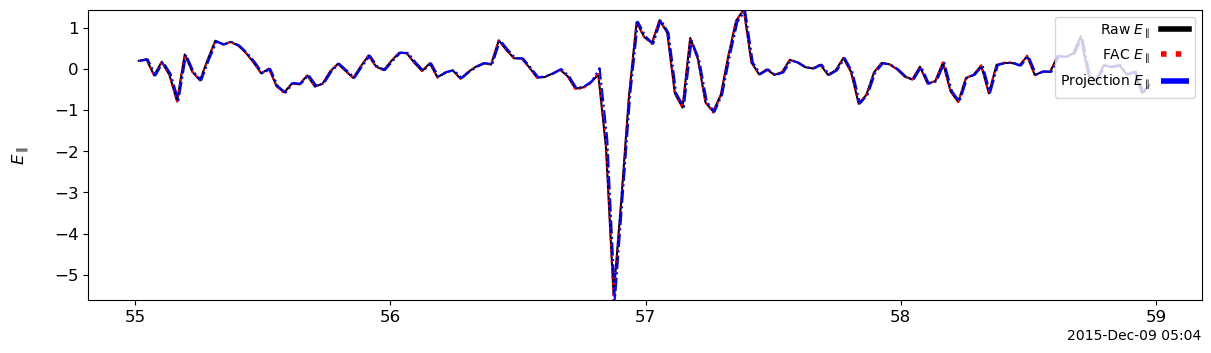

In [68]:
# Combine the three tplot variables into one
pyspedas.store_data('combined_epar', data=['epar_gse_avg_noerr', 'epar_gse_fac',
                                           'epar_gse_dotp'])

# Set legend names
pyspedas.options('combined_epar', 'legend_names', ['Raw $E_{\\parallel}$',
                                                   'FAC $E_{\\parallel}$',
                                                   'Projection $E_{\\parallel}$'])

# Set line colors
pyspedas.options('combined_epar', 'colors', ['black', 'red', 'blue'])

# Set line styles (0: solid, 1: dashed, 2: dotted)
pyspedas.options('combined_epar', 'line_style', ['solid_line', 'dot', 'dash_dot'])

# Set line width
pyspedas.options('combined_epar', 'line_width', 1.5)

# Set y-axis label
pyspedas.options('combined_epar', 'ytitle', '$E_{\\parallel}$')

# Plot
pyspedas.tplot('combined_epar', xsize=12, ysize=3.5, 
               save_png='Fig4_Nov3_fac_comparison.png')
